# Plotting Audio Samples

In [109]:
import torchaudio
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import signal
import essentia
import essentia.standard as esstd
import numpy as np
import seaborn as sns
from matplotlib import cm, colors
from matplotlib.ticker import ScalarFormatter
import numpy as np
from scipy.signal import spectrogram, get_window
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 6) # set plot sizes to something larger than default

In [110]:
sample_rate = 48000
SAMPLES_DIR = Path("../results/48k/audio")

start_time = int(sample_rate * 9.9)
end_time =  int(sample_rate * 10.5)

FFT_N = 2**8
print(f"FFT_N: {FFT_N}")

FFT_N: 256


In [111]:
def check_dc_offset(pred, target):
    pred_offset = pred.mean()
    target_offset = target.mean()
    dc_offset = pred_offset - target_offset

    # Smallest quantization step for 16-bit audio
    quantization_step_16bit = 1 / 32767.0

    # Check if the absolute value of the DC offset is smaller or larger than the quantization step
    if abs(dc_offset) < quantization_step_16bit:
        print("The DC offset is smaller than the smallest quantization step for 16-bit audio.")
    else:
        print("The DC offset is larger than the smallest quantization step for 16-bit audio.")

In [112]:
def overlap_waveforms(o, t, sample_rate, start, end, title):    

    o_zoom = o[start:end]
    t_zoom = t[start:end]

    # create time vector
    time = range(start, end)

    plt.figure()
    plt.plot(time, o_zoom, alpha=0.8, label="Model")
    plt.plot(time, t_zoom, alpha=0.8, label="Target")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    # plt.savefig(f"../results/plots/{title}_waves.png")
    plt.show()

In [113]:
def target_output_spectra(o, t, sample_rate, start, end, title):

    o_zoom = o[start:end]
    t_zoom = t[start:end]

    # N = int(len(o_zoom))         # Number of sample points
    # T = N // 16              # sample spacing

    # fft_value = N // 8
    # overlap = T
    # ratio = fft_value // 4
    # seg = ratio
    # w = get_window('blackmanharris', )


    freq_o, times_o, Sxx_o = spectrogram(
        o_zoom, 
        fs=sample_rate,
        scaling='spectrum', 
        mode='magnitude'
    )
    freq_t, times_t, Sxx_t = spectrogram(
        t_zoom, 
        fs=sample_rate, 
        scaling='spectrum', 
        mode='magnitude'
    )

    # Convert magnitude to dB
    o_Sxx_dB = 10 * np.log10(Sxx_o + 1e-10)
    t_Sxx_dB = 10 * np.log10(Sxx_t + 1e-10)

    average_o = np.mean(o_Sxx_dB, axis=1)
    average_t = np.mean(t_Sxx_dB, axis=1)

    plt.plot(freq_o, average_o, alpha=1, label="Model", linewidth=0.8)
    plt.plot(freq_t, average_t, alpha=1, label="Target", linewidth=0.8)
    
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    # plt.xscale('symlog')  # Frequency should often be plotted on a log scale
    # plt.xlim([20, 12000])
    plt.title(title)
    # plt.xlabel('Frequency (Hz)')
    plt.ylabel('Average Magnitude (dB)')
    
    # Use ScalarFormatter to avoid scientific notation
    # ax = plt.gca()
    # ax.xaxis.set_major_formatter(ScalarFormatter())
    # ax.xaxis.get_major_formatter().set_scientific(False)
    # ax.xaxis.get_major_formatter().set_useOffset(False)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [114]:
def process_directory(directory_path, start, end):
    """
    Walk through directory_path, and for each pair of out_{some_model_name}.wav and tgt_{same_model_name}.wav, 
    load them using torchaudio and call overlap_waveforms and two_spectrograms_difference functions.
    """
    directory_path = Path(directory_path)
    output_files = [f for f in directory_path.iterdir() if f.name.startswith("out_") and f.suffix == ".wav"]
    
    for out_file in output_files:
        # Extract the model name and sample rate by splitting on '_'. 
        # This assumes the format is consistent with what's shown.
        parts = out_file.stem.split("_")
        model_name = "_".join(parts[1:-1])  # Combine everything except 'out' and sample rate.
        sample_rate_suffix = parts[-1]
        
        # Construct the expected name for the tgt file
        tgt_file_name = f"tgt_{model_name}_{sample_rate_suffix}.wav"
        tgt_file = directory_path / tgt_file_name
        
        if tgt_file.exists():
            # Load the audio files using torchaudio
            output, sample_rate = torchaudio.load(out_file)
            target, _ = torchaudio.load(tgt_file)
            
            output = output.view(-1).numpy()
            target = target.view(-1).numpy()

            title = model_name + "_" + sample_rate_suffix
            
            # Call your functions
            overlap_waveforms(output, target, sample_rate, start, end, title)
            target_output_spectra(output, target, sample_rate, start, end, title)
        else:
            print(f"Matching target file for {out_file} not found!")

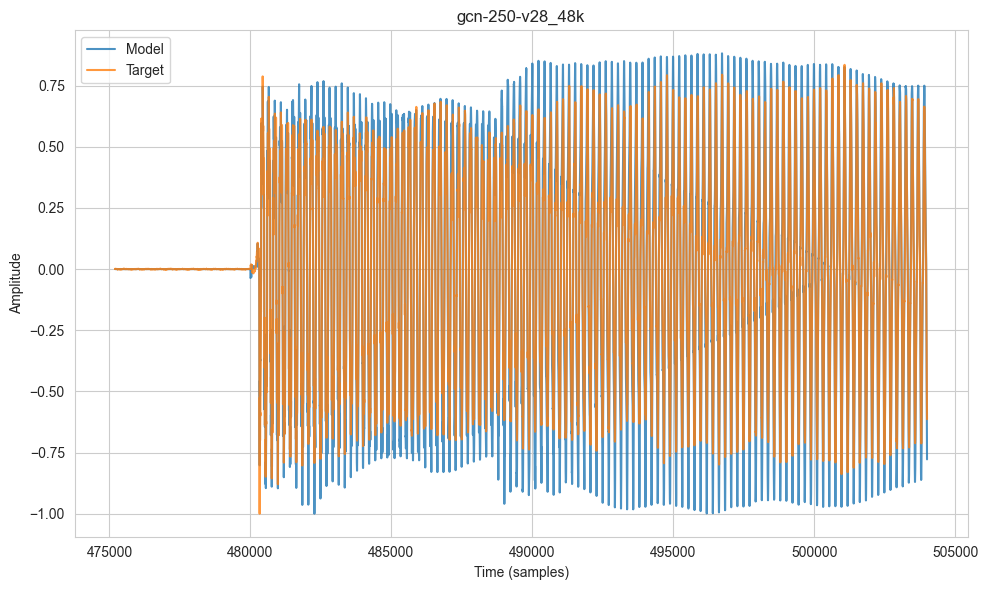

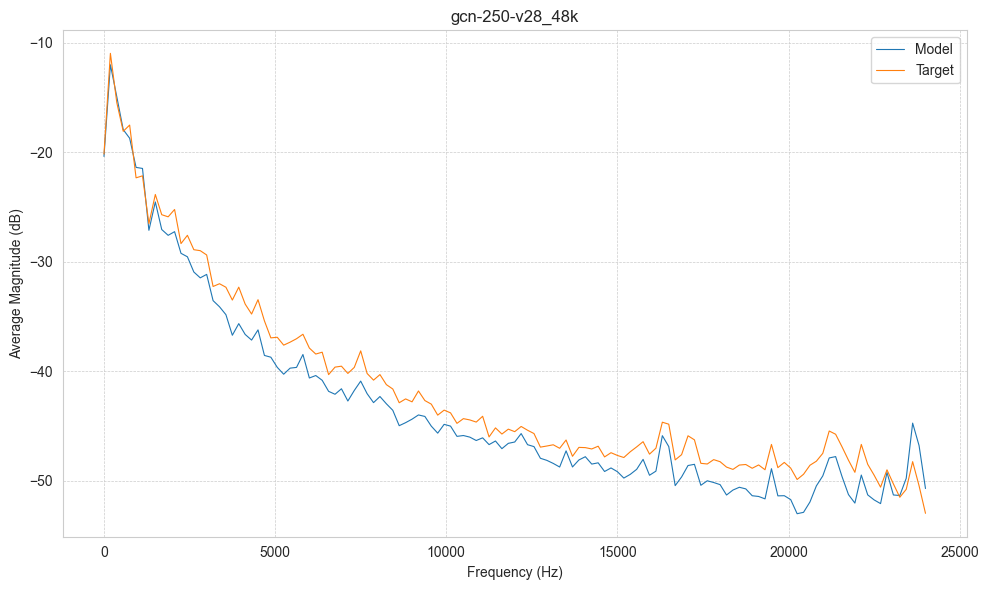

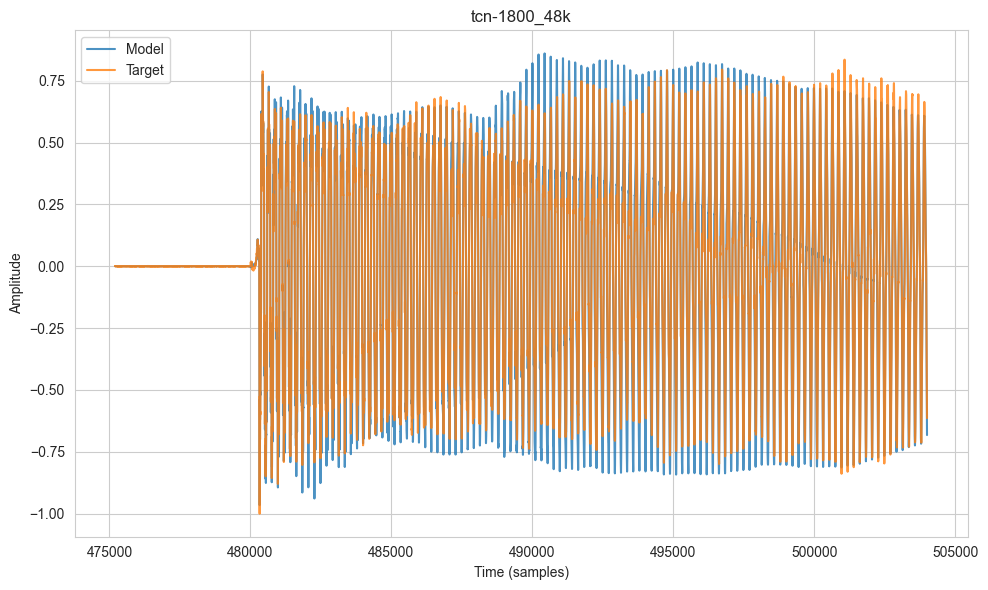

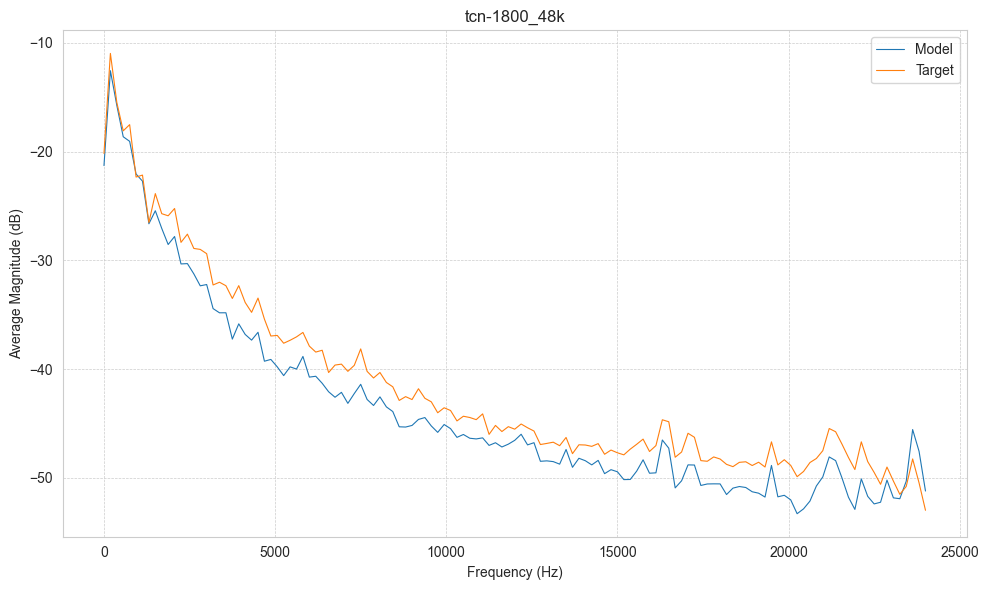

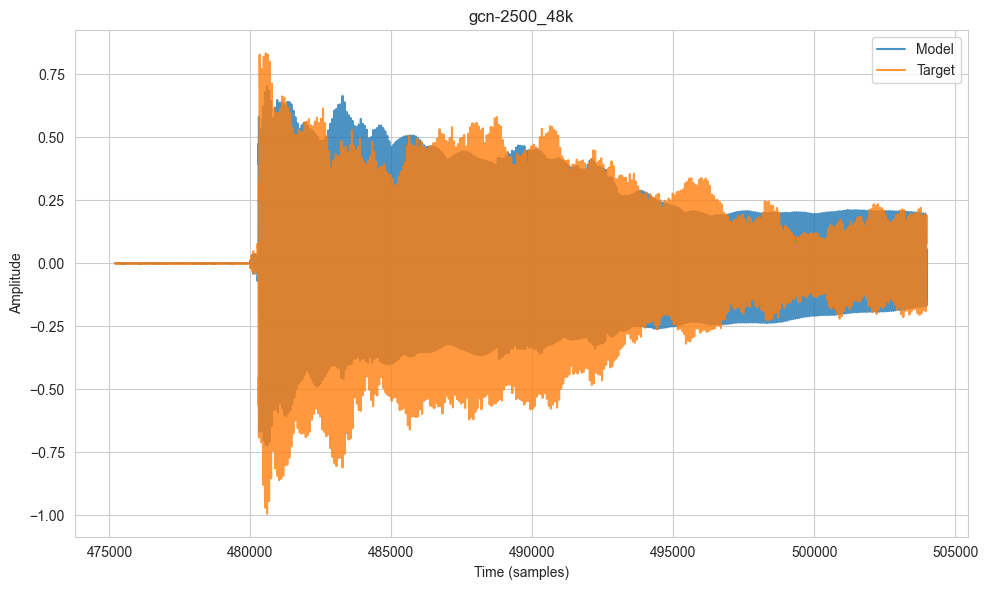

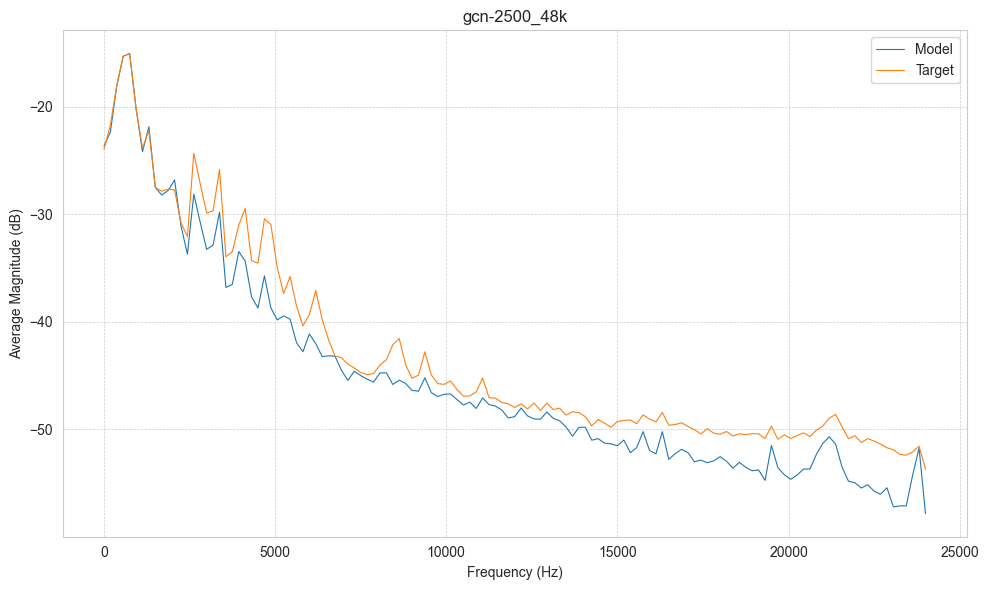

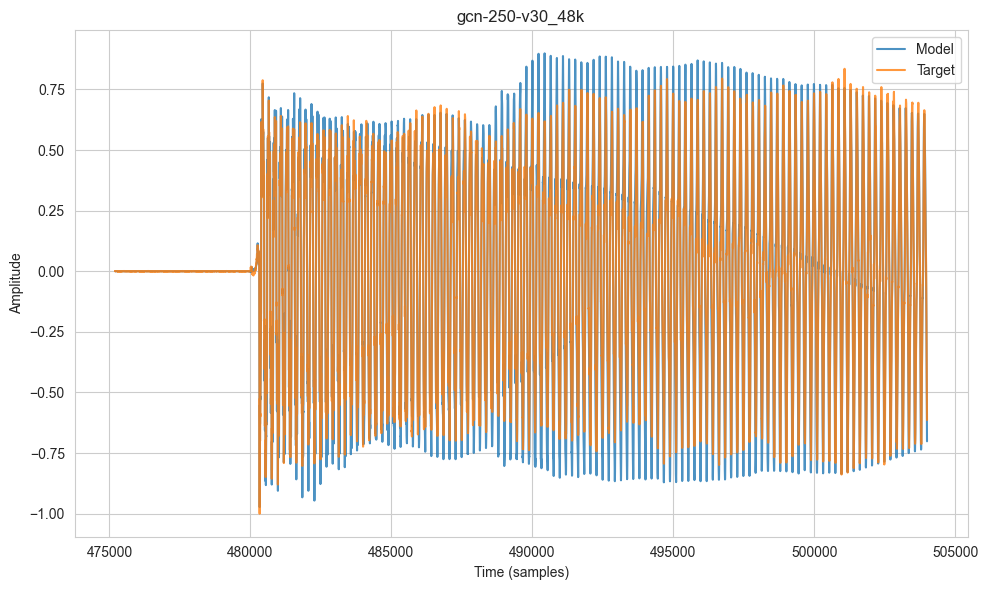

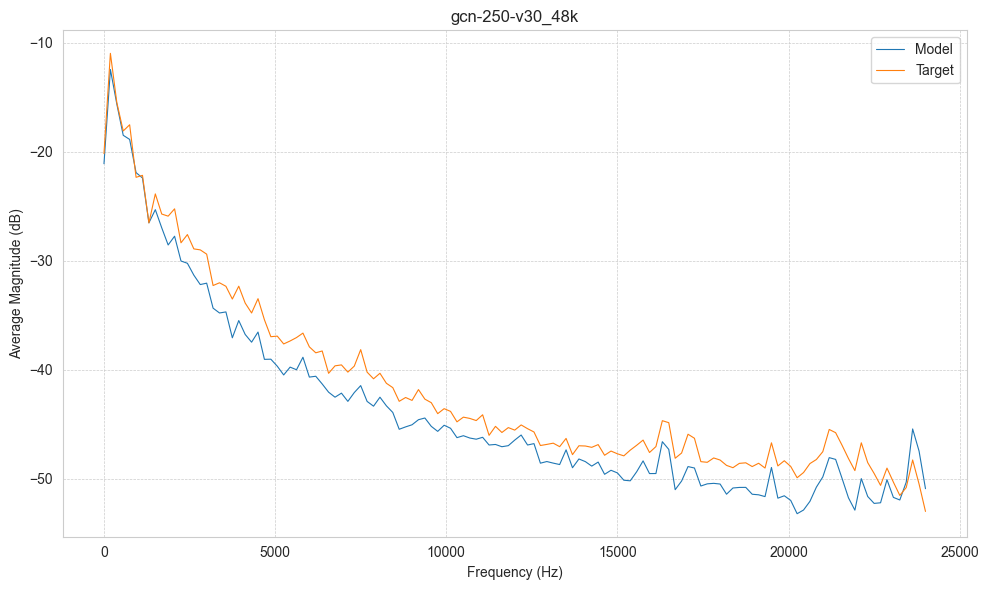

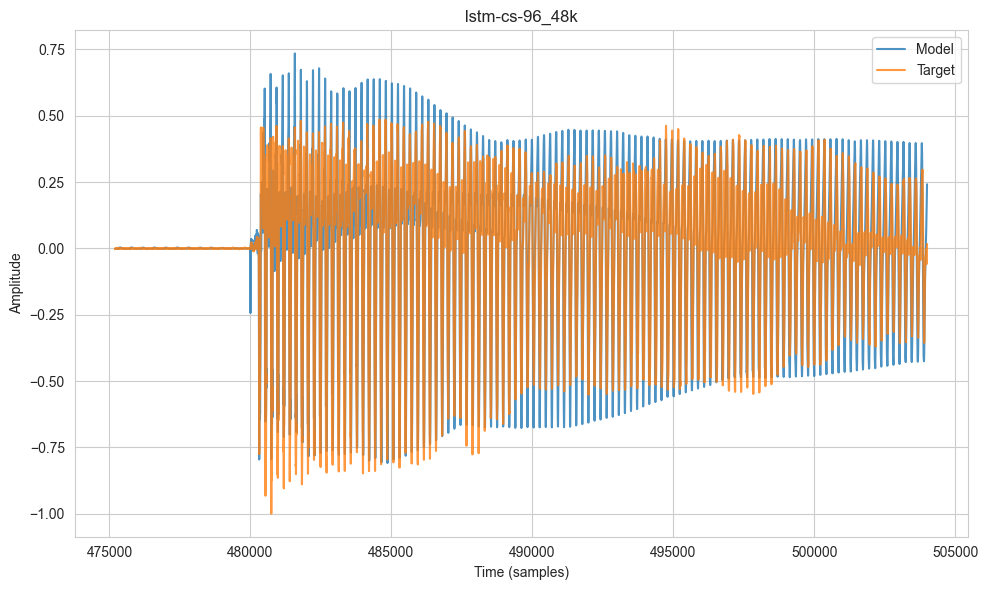

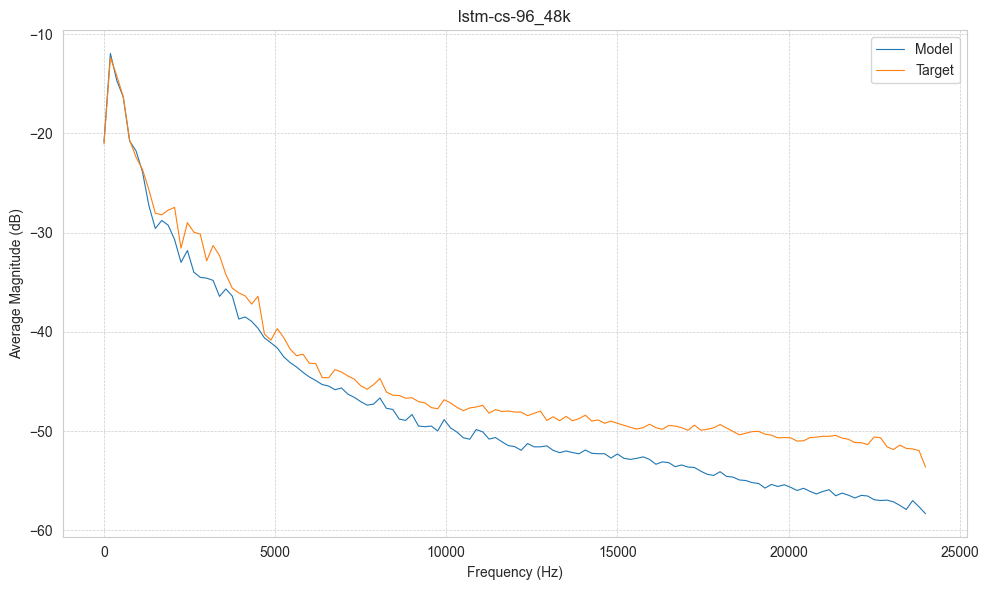

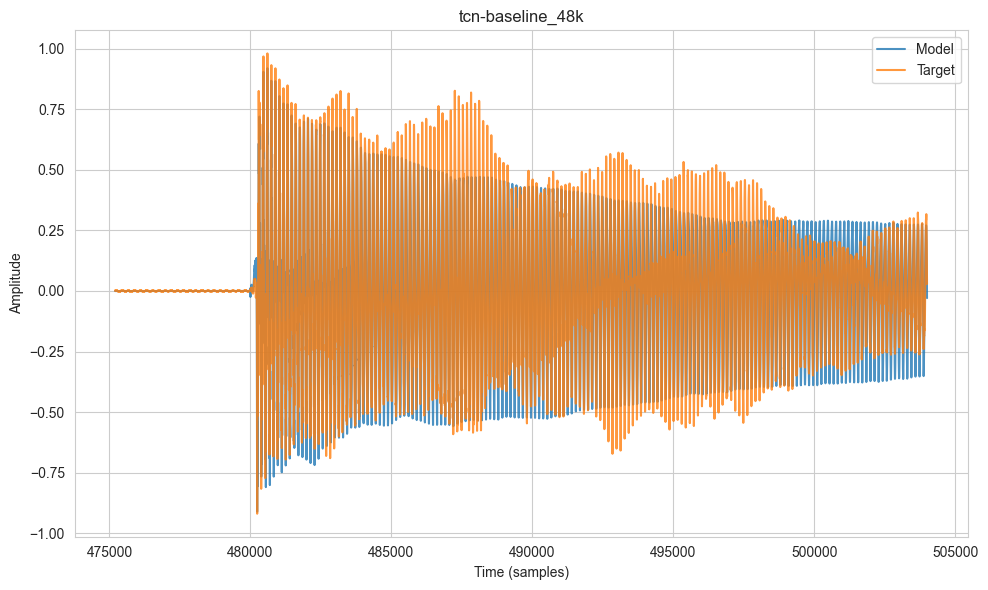

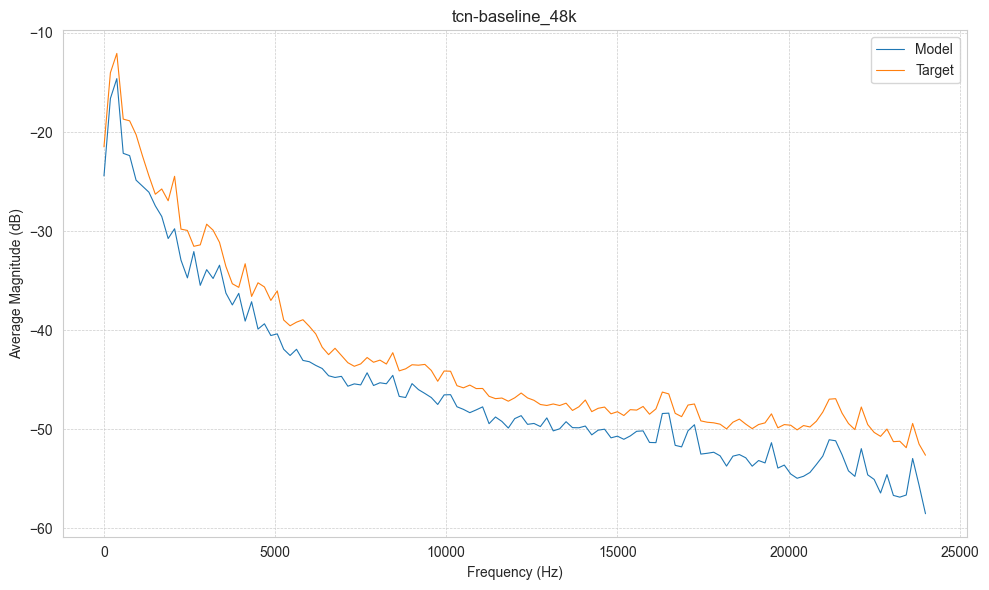

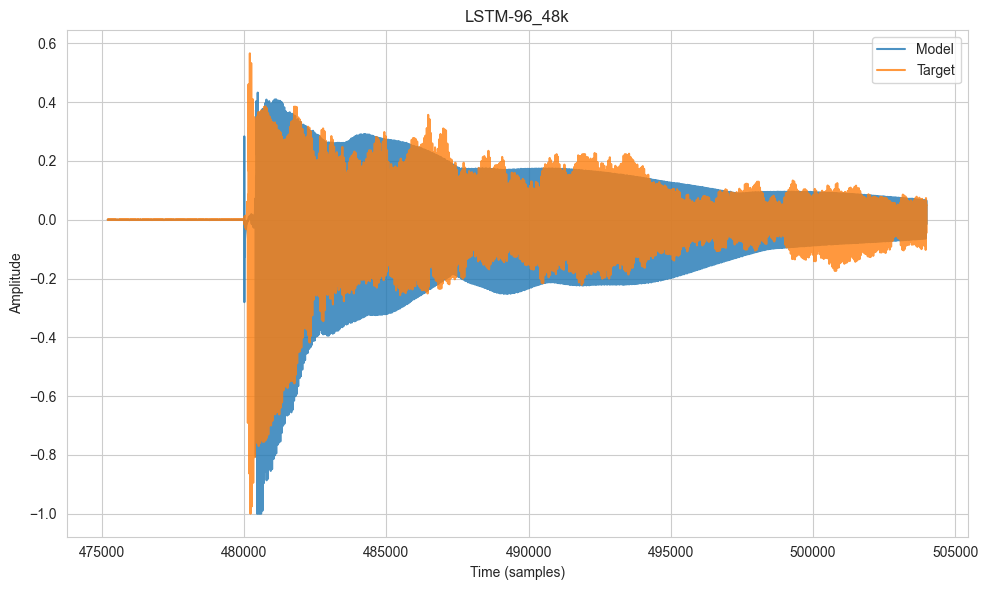

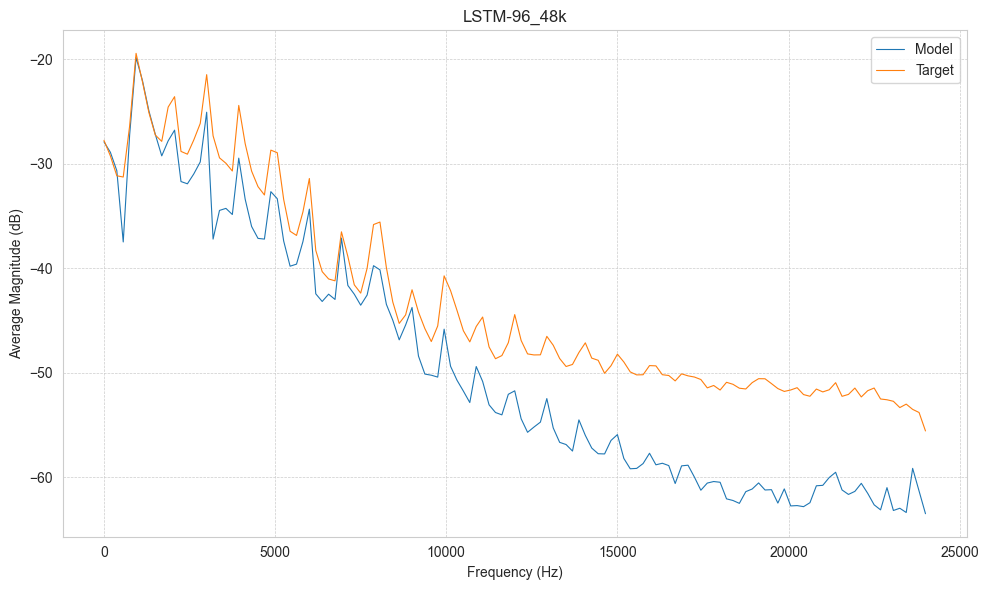

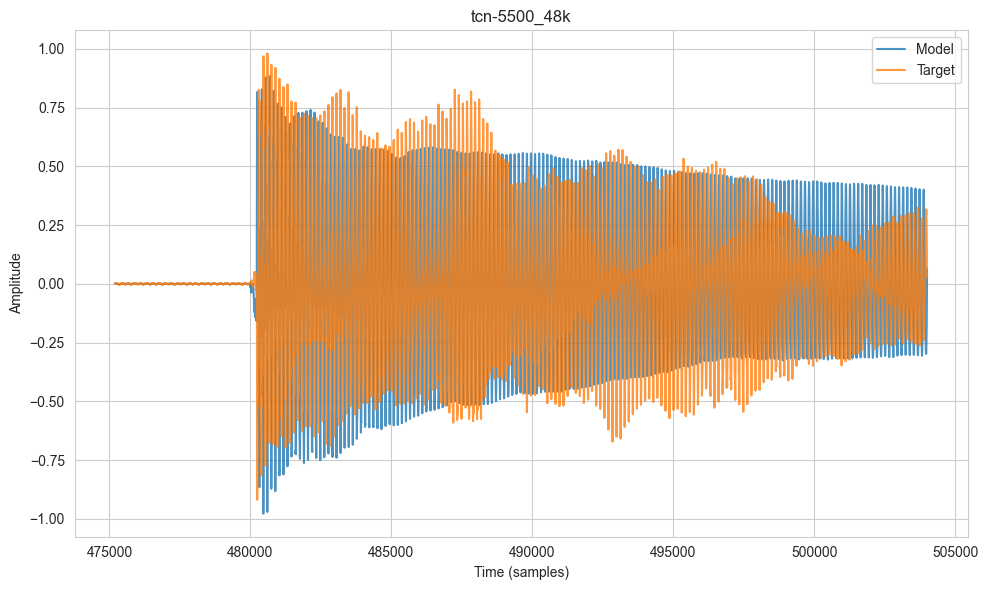

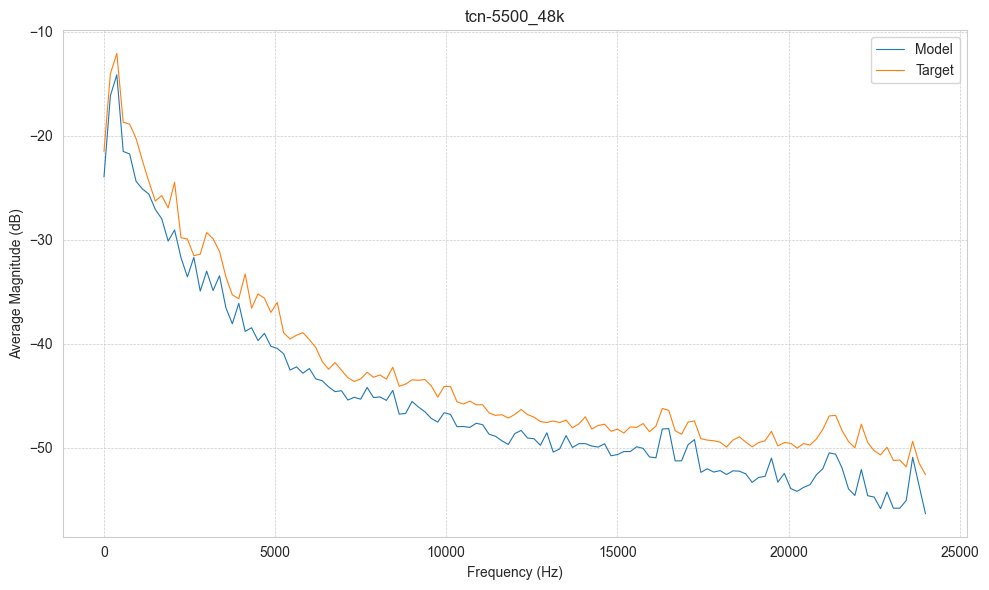

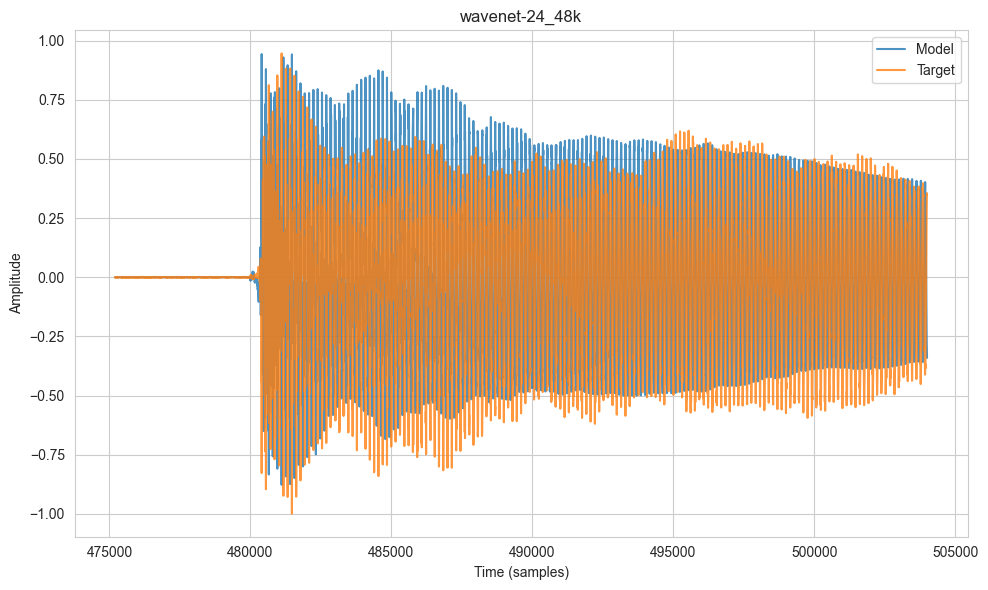

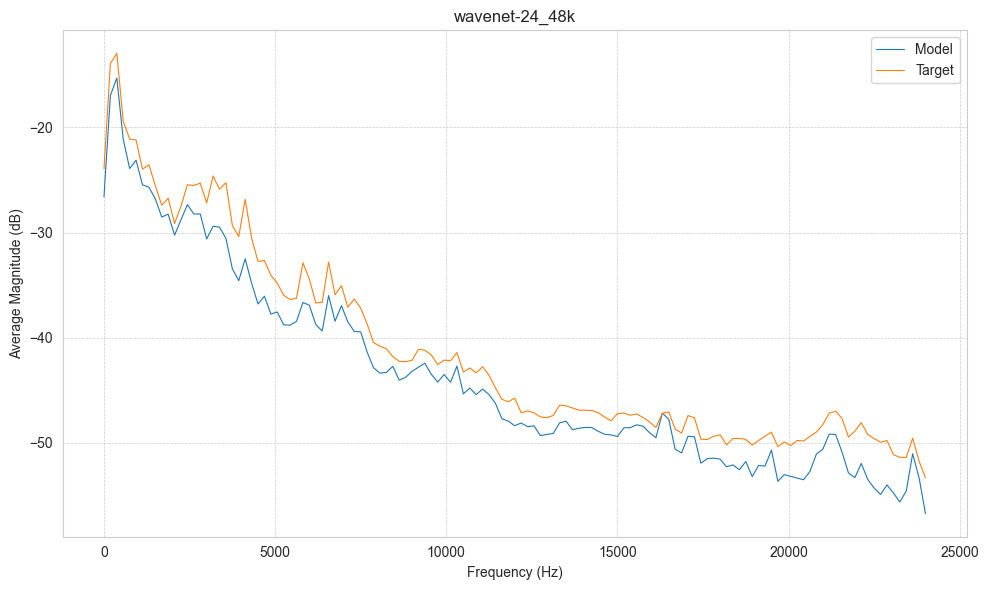

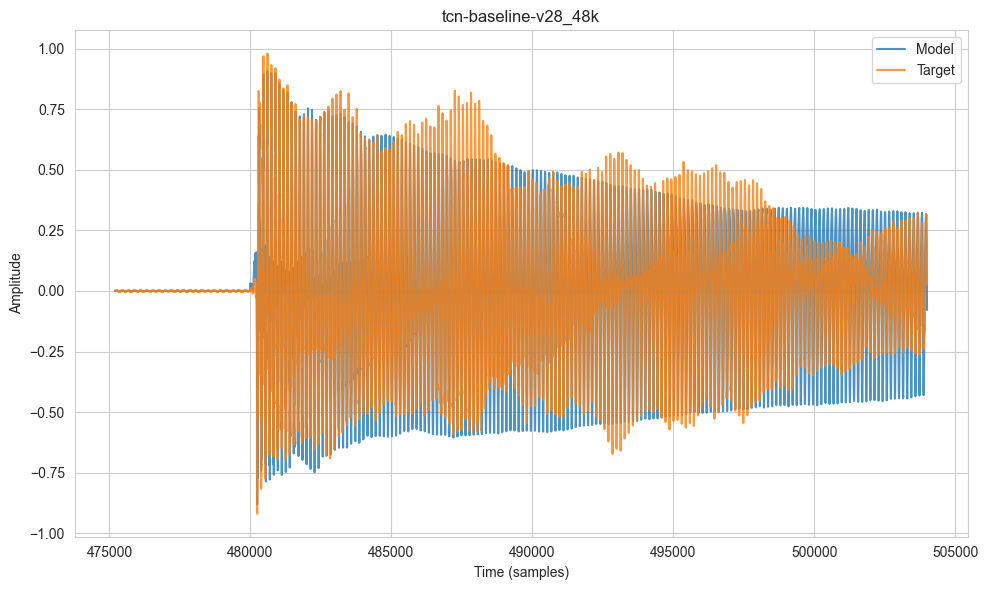

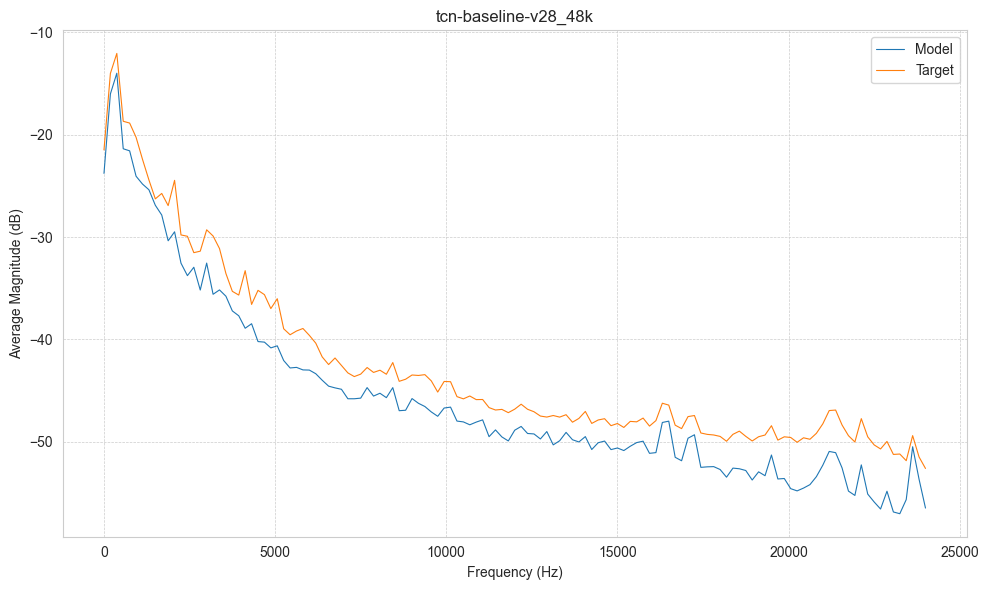

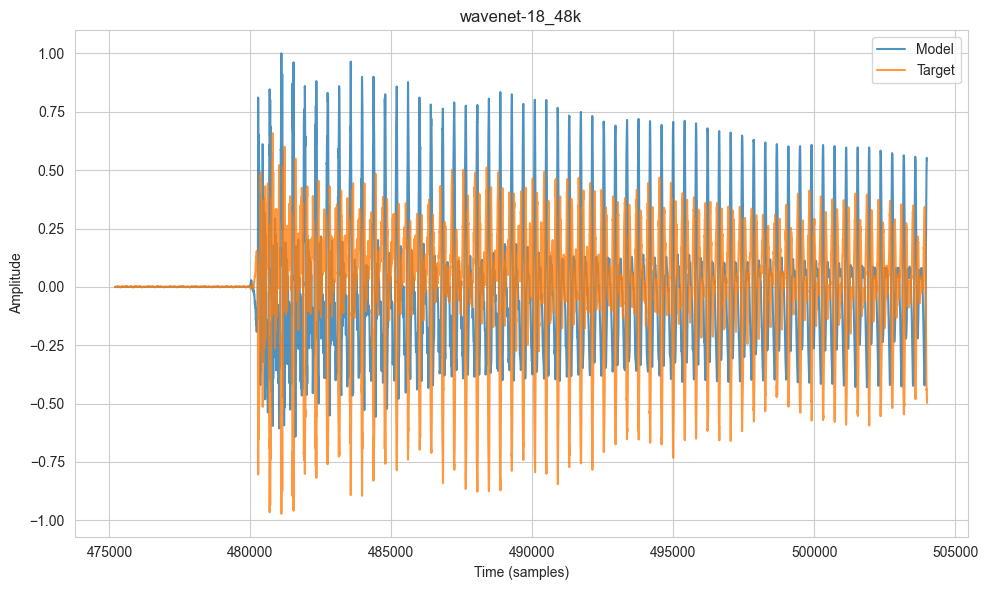

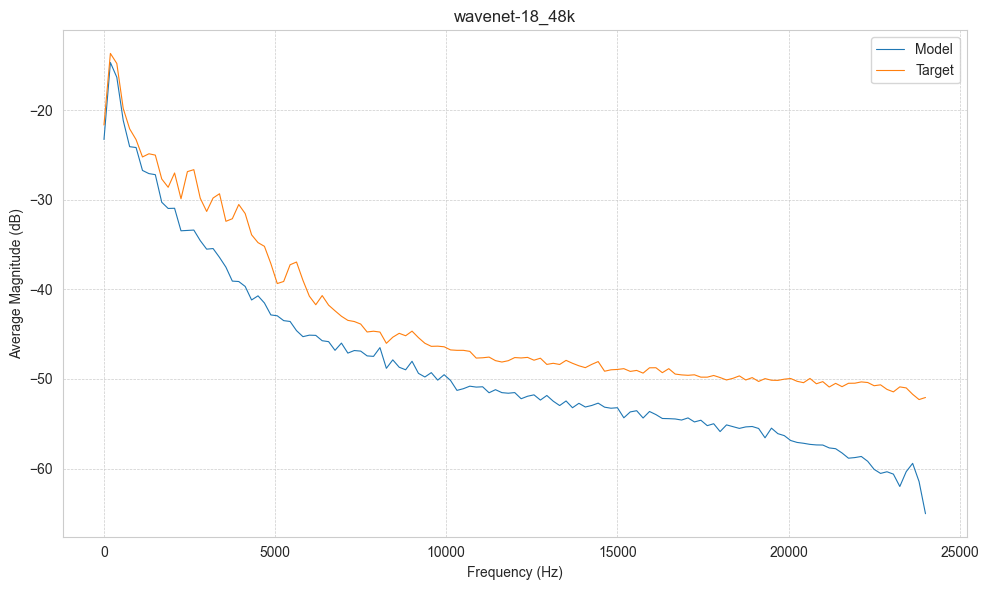

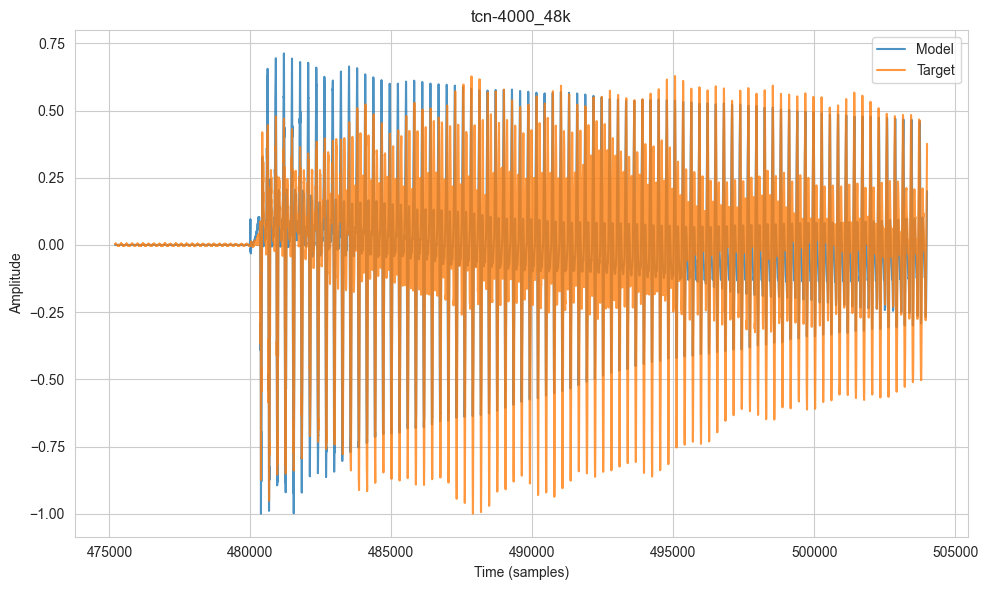

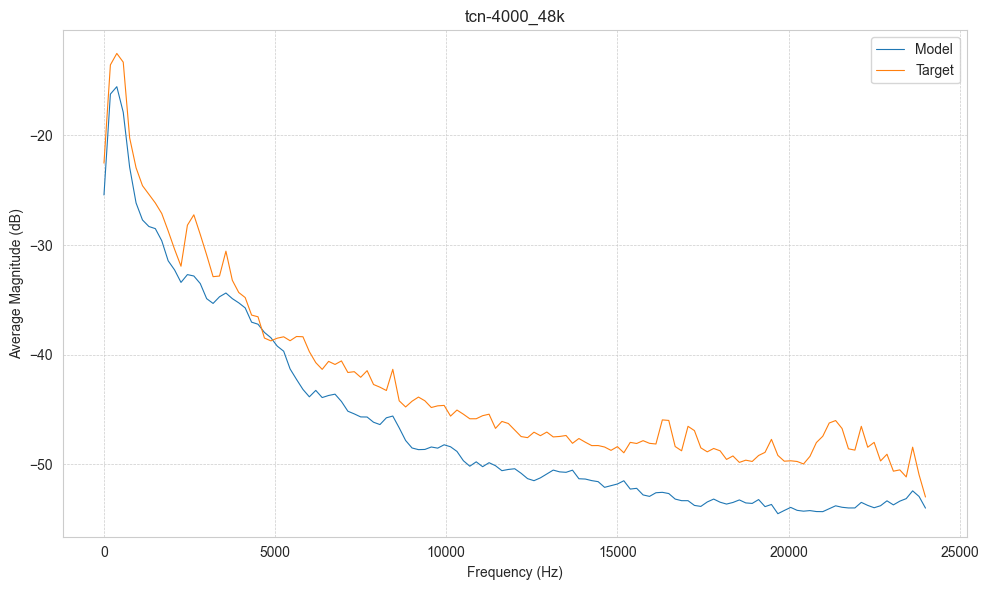

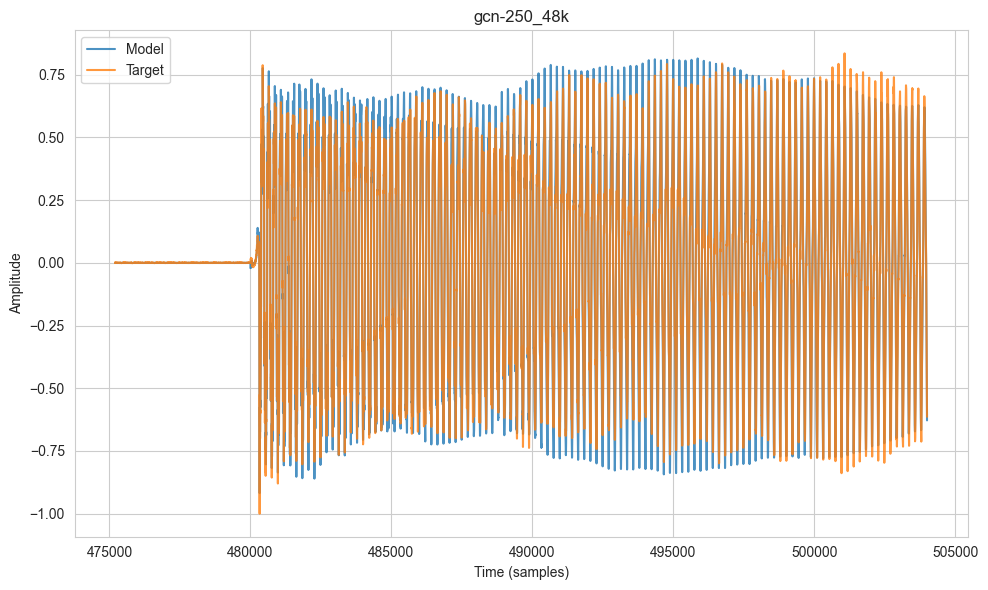

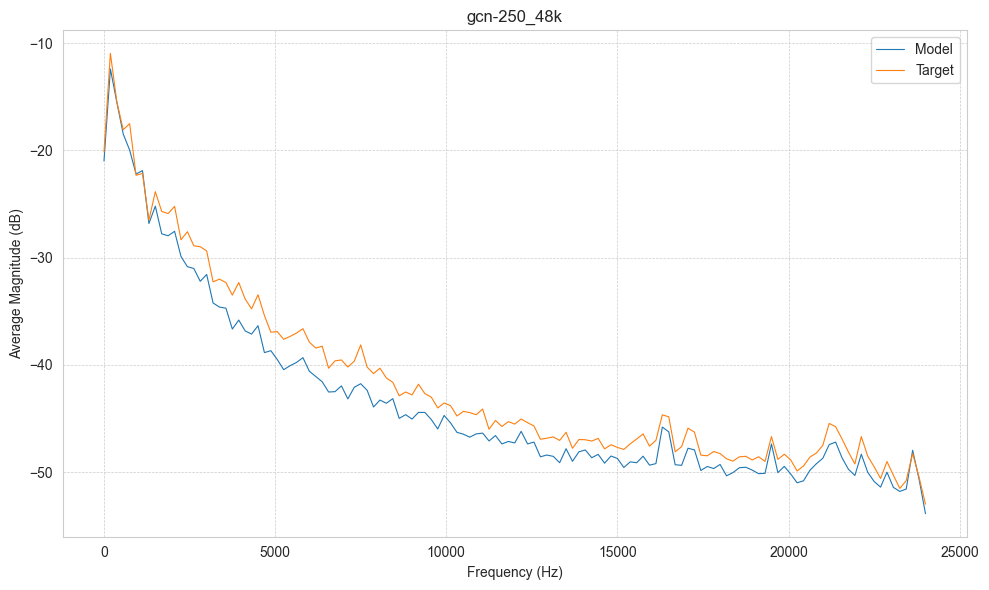

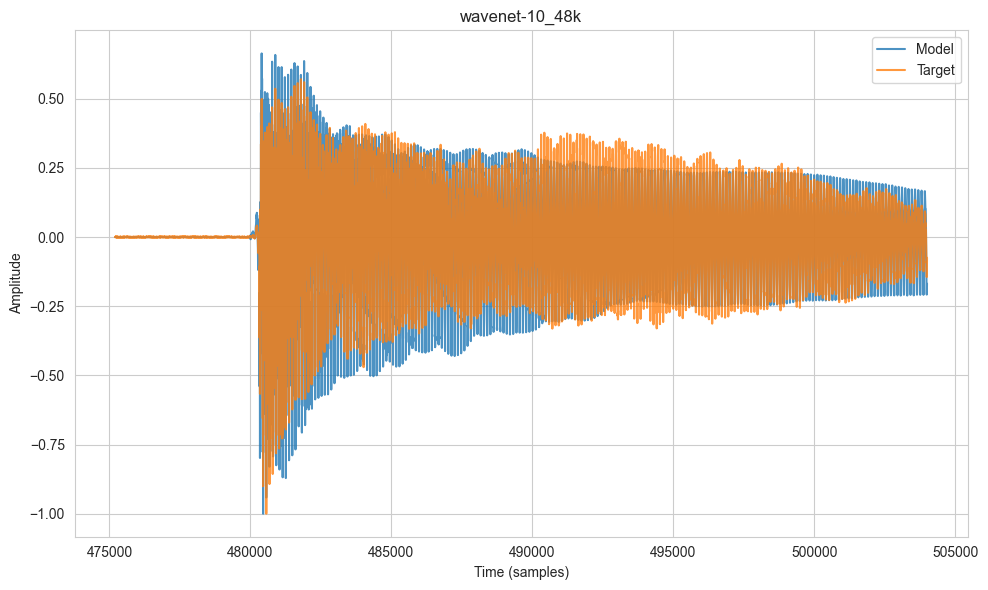

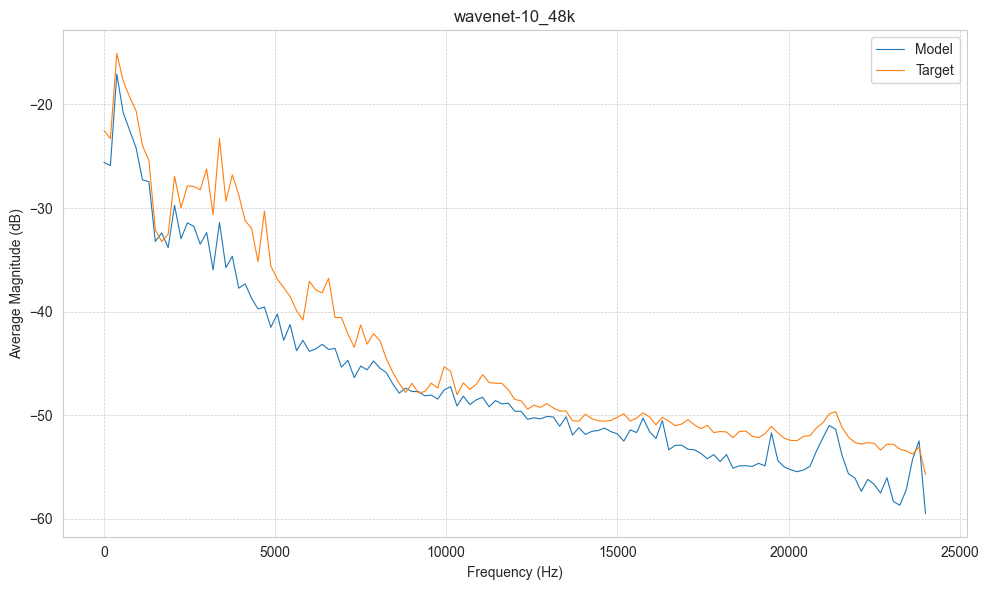

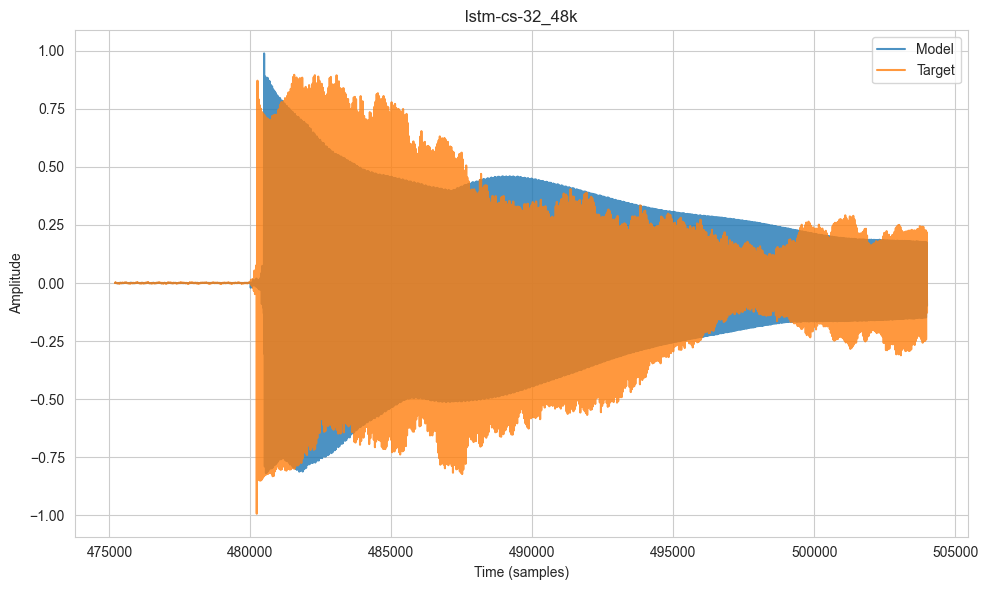

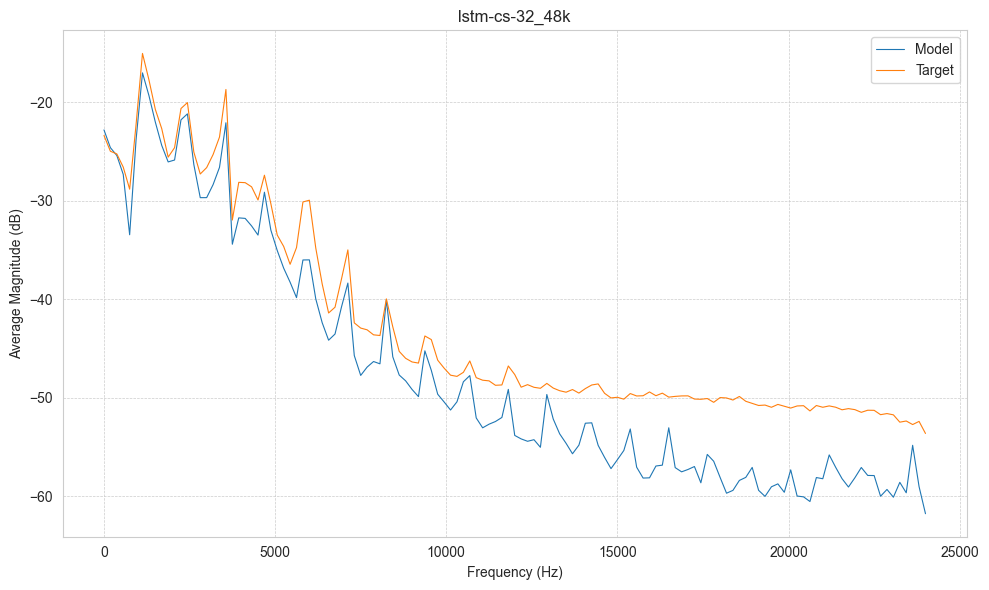

In [115]:
process_directory(SAMPLES_DIR, start_time, end_time)

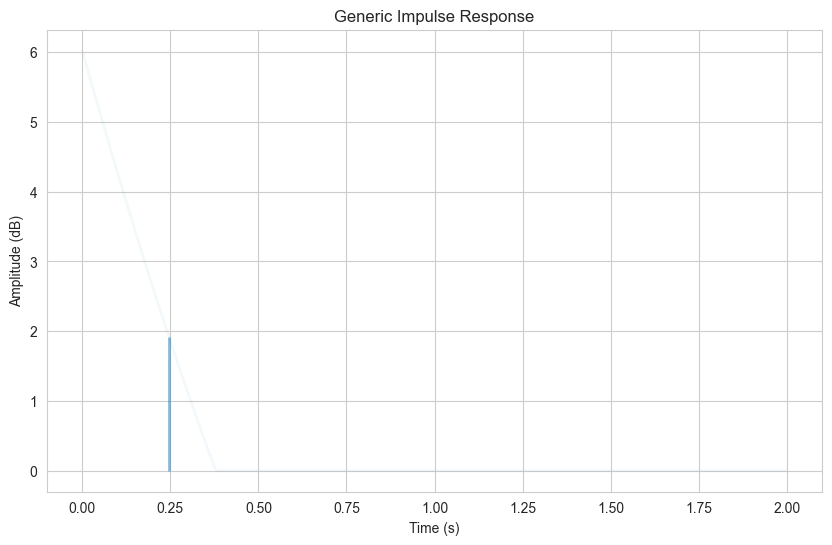

In [116]:
import numpy as np
import matplotlib.pyplot as plt

# Generate time values
fs = 22050  # Sampling frequency (adjust as needed)
t_max = 2.0  # Maximum time in seconds
t = np.linspace(0, t_max, int(fs * t_max))

# Generate impulse response with a decay pattern
direct_sound = np.exp(-t * np.pi)  # Example decay rate
late_reverberation = np.exp(np.tanh(-t))  # Example decay rate for late reverberation
impulse_response = direct_sound + late_reverberation

# Convert amplitude to dB
impulse_response_db = 20 * np.log10(impulse_response)
impulse_response_db[impulse_response_db < 0] = 0  # Set negative values to zero dB

# Number of vertical lines to generate in each section
num_lines_section1 = 1
num_lines_section2 = 50
num_lines_section3 = 250

# Divide the time range into three sections
t_section1 = t[t <= t_max / 3]
t_section2 = t[(t > t_max / 3) & (0.8 * t <= 2 * t_max / 3)]
t_section3 = t[t > 2 * t_max / 3]

# Generate random x-coordinates for each section
x_coords_section1 = np.random.choice(t_section1, num_lines_section1)
x_coords_section2 = np.random.choice(t_section2, num_lines_section2)
x_coords_section3 = np.random.choice(t_section3, num_lines_section3)

# Generate vertical line heights based on the impulse response dB values
line_heights_section1 = np.interp(x_coords_section1, t, impulse_response_db)
line_heights_section2 = np.interp(x_coords_section2, t, impulse_response_db)
line_heights_section3 = np.interp(x_coords_section3, t, impulse_response_db)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(t, impulse_response_db, label="Impulse Response", linewidth=2, alpha=0.05)
plt.vlines(x_coords_section1, ymin=0, ymax=line_heights_section1, alpha=0.5, linewidth=2, )
plt.vlines(x_coords_section2, ymin=0, ymax=line_heights_section2, alpha=0.5, linewidth=2, cmap="viridis")
plt.vlines(x_coords_section3, ymin=0, ymax=line_heights_section3, alpha=0.5, linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (dB)")
plt.title("Generic Impulse Response")
plt.show()